In [1]:
# import stats packages
import xarray
import cftime
import sys, os
import glob
#import fiona
import numpy as np
import pandas as pd
import ipywidgets as widgets
from netCDF4 import Dataset 
from datetime import datetime as dt
import matplotlib.pyplot as plt

# import spatial modules
import ee
import geemap
#from osgeo import gdal #install with pip3, don't use conda

# don't display warnings
import warnings
warnings.filterwarnings('ignore') 

In [2]:
#******************************** extract model outputs ******************************#
# select case run output directories
output_rootdir=os.path.expanduser('~')+'/output/cime_run_dirs/'
cases=np.asarray(glob.glob("%s*20TR*" % output_rootdir))
cases=[x.split('/')[-1] for x in cases]
cases_dropdown = widgets.Dropdown(options=cases,
                                description='Chose Case Name:',
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                  disabled=False)
# show a dropdown menu to select specific case output
# any cases that have been run in our elmoutput directory will be displayed
# case names will contain the site codes:
# AK-BEO; AK-CLG; AK-K64G AK-TLG
display(cases_dropdown)

Dropdown(description='Chose Case Name:', layout=Layout(width='max-content'), options=('OLMT_AK-K64G_ICB20TRCNP…

In [3]:
# select model output file
output_casedir=output_rootdir+cases_dropdown.value+'/run/'
filenames=np.asarray(glob.glob("%s*.elm.h?.*.nc" % output_casedir))
filenames=sorted([x.split('/')[-1] for x in filenames])
if(os.path.exists(output_casedir+'ELM_output.nc')): filenames.insert(0,'ELM_output.nc')

ncfiles_dropdown = widgets.Dropdown(options=filenames,
                                description='Choose Output File:', 
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)
# display the output nc file options - in most cases you will select ELM_output.nc
display(ncfiles_dropdown)

Dropdown(description='Choose Output File:', layout=Layout(width='max-content'), options=('ELM_output.nc', 'OLM…

In [4]:
# select the variables for visualization
output_file=output_casedir+ncfiles_dropdown.value
# extract variables in model outputs
fnc=Dataset(output_file)
vars=fnc.variables
vars_names=vars.keys()
vars_dims={}; vars_units={};
for v in vars: 
    vars_dims[v]=vars[v].dimensions
    if(hasattr(vars[v], 'units')):
        vars_units[v]=vars[v].units
    else:
        vars_units[v]='-'    
fnc.close()
vars_dropdown = widgets.Dropdown(options=vars_names,
                                description='Choose Variable Name',
                                style={'description_width':'auto'},
                                value='GPP',
                                layout={'width':'max-content'},
                                disabled=False)
# display a dropdown of model parameters
display(vars_dropdown)

Dropdown(description='Choose Variable Name', index=188, layout=Layout(width='max-content'), options=('levgrnd'…

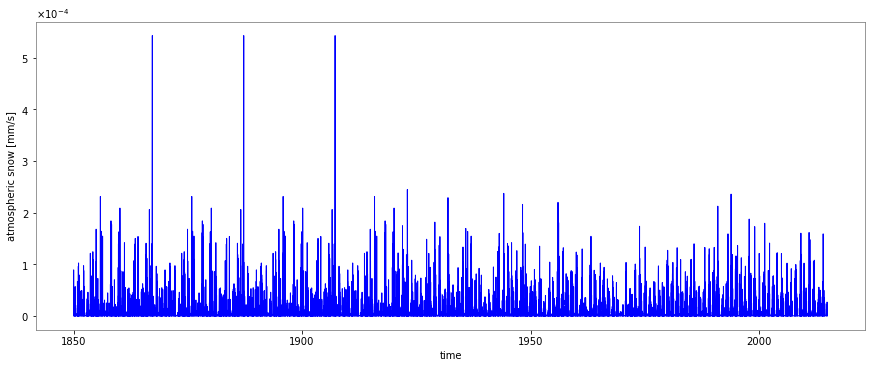

In [41]:
# extract variable from model outputs
var_name=vars_dropdown.value
# load in model output data
elm_output=xarray.open_dataset(output_file).squeeze()
# make a quick plot
var_data = elm_output[str(var_name)]
fig, ax = plt.subplots(clear=True, figsize=(12,5))
var_data.plot(ax=ax,linestyle='-',color='blue',label= var_name)

In [6]:
#*******************************************************************************#
# this section presents an example to compare model outputs with long-term 
# remote sensing observation using data stored on GEE
#*******************************************************************************#
#********************************* Initialize GEE  ***********************************#
#     !!!!!!!!!! please register a GEE account before preceeding !!!!!!!!!! 
## trigger the authentication flow. only need once
ee.Authenticate()
## After inserting the API key initialize GEE
ee.Initialize()


Enter verification code:  4/1ARtbsJqgoiT-xirXs8RgmoDdI6IAJGFO_79XdwBpieHDABi5XAhjhwnltvQ



Successfully saved authorization token.


In [7]:
#****************************** define user parameters *******************************#
# setup output directory
outDIR="/home/jovyan/work/"

# setup date range in which MODIS data will be extracted for comparison
dateBEG = "2000-01-01"
dateEND = "2014-12-31"
# setup month in which MODIS data will be extracted 
monBEG = 1
monEND = 12

# set visualization parameters.
lst_vis_params = {
    'min': 70,
    'max': 100,
    'palette': ['21325E', '662A00', 'F6F54D']
}

# define variable name from MODIS data and scale factor
#!!!!!! IMPORTANT:PLEASE CHECK THE GEE DATA SOURCE FOR BANDNAMES and SCALE!!!!!!!
imagecollection = 'MODIS/006/MOD17A2H'  #MODIS/006/MOD17A2H
varname = 'Gpp' #band name of the variable in modis data Gpp
scale_factor = 0.0001
# for modis image collection on GEE, please check
# https://developers.google.com/earth-engine/datasets/catalog/modis

In [36]:
#********************************* load in data **************************************#
# load in modis data
modCOLL = ee.ImageCollection(imagecollection).filter(ee.Filter.date(ee.Date(dateBEG), ee.Date(dateEND)))
modCOLL = modCOLL.filter(ee.Filter.calendarRange(monBEG,monEND,'month'));
# count the number of images found
count = modCOLL.size()
print('Count: ', str(count.getInfo())+'\n')
# extract corresponding rs data from image collection;
modGPP = modCOLL.select(varname)

# define the boundary of model grid
# choice #1: load in a polygon if you have one
#shpDIR = "/home/jovyan/work/kougarok.shp"
#shpVCT = geemap.shp_to_ee(shpDIR)
# choice #2 define a circle if model location if accurate
#lat = elm_output[str('lat')]
#lon = elm_output[str('lon')]
#point = ee.Geometry.Point(float(lon.values), float(lat.values))
#shpVCT = point.buffer(1000) # buffer radius in meters
# choice #3 manually define a point and create a circle boundray
lat = 65.16  #float(elm_output[str('lat')].values)
lon = -164.81  #float(elm_output[str('lon')].values)
point = ee.Geometry.Point(lon, lat)
shpVCT = point.buffer(500) # buffer radius in meters

Count:  683



In [37]:
#************************ preprocessing rs data *********************************#
# clip out the region defined by shp file
def geeclip (image):
    return image.clip(shpVCT)
modGPP_CLP = modGPP.map(geeclip)

# make a quick display using the mean value of all image collections
modGPP_MN = modGPP_CLP.reduce(ee.Reducer.mean())
Map = geemap.Map() #center=(65.16, -164.82), zoom=13
Map.centerObject(shpVCT, 13)
Map.addLayer(shpVCT, {}, 'ROI')
Map.addLayer(modGPP_MN, lst_vis_params, '', True, 1)
Map.add_colorbar(vis_params=lst_vis_params, label=varname)
Map

Map(center=[65.16000051296315, -164.80999996613681], controls=(WidgetControl(options=['position', 'transparent…

In [38]:
#************************ calculate polygon mean time series *******************#
def extract_time_series(imgcoll, shp, band_name):
    # Obtain image collection for all images within query dates
    # Get list of images which correspond with the above
    images = [item.get('id') for item in imgcoll.getInfo().get('features')]
    # create matrix to store the data
    store = []
    date_store = []
    # Loop over all images and extract pixel value
    for image in images:
        im = ee.Image(image)
        projection = im.projection().getInfo()['crs']
        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))
        # Extract pixel value
        data = im.reduceRegion(ee.Reducer.mean(),
                               shp,
                               500,
                               crs=projection)
        # store extract data
        store.append(data.get(band_name).getInfo())
    # Convert output into pandas data frame
    df = pd.DataFrame(index = date_store, data = store)
    return df

modGPP_TS = extract_time_series(modGPP_CLP, shpVCT, varname)
modGPP_TS.columns = [var_name]

Text(0, 0.5, 'GPP')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


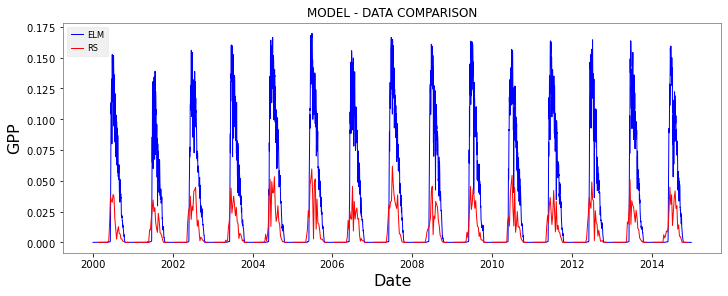

In [40]:
#*************************** plot model data comparison ************************#
# extract model data within the range of rs data
timerange = slice(dateBEG, dateEND)
model_extr = var_data.sel(time = timerange)
# conver xarray to dataframe
model_extr_df = model_extr.to_dataframe()
temptime = model_extr.indexes['time'].to_datetimeindex()
model_extr_df_corr = pd.DataFrame(index=temptime, data=model_extr_df.values[:,0])
model_extr_df_corr.columns = [var_name]
# convert model output to the same unit with RS data
model_data_plot = model_extr_df_corr*1000  #!!!!!please change this factor 1000 correspondingly

# apply the scale factor to rs data
rs_data_plot = modGPP_TS*scale_factor

# make a plot that shows both model and rs data
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(model_data_plot, color = 'b', label = 'ELM')
plt.plot(rs_data_plot, color = 'r', label = 'RS')
plt.legend(loc="upper left")
ax.set_title('MODEL - DATA COMPARISON', size = 12)
ax.set_xlabel('Date', size=16)
ax.set_ylabel(var_name, size=16)